# series oof df
series_idごとのoof scoreをチェック
errorがどういう波形に対して発生しているかを確認する

In [17]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [18]:
import sys
sys.path.append("/kaggle/src/dss_utils")

from dss_metrics import score

# Config

In [19]:
output_dir = os.path.join("/kaggle", "working", "_oof")
exp_name = "exp006_addlayer"

# fn

In [20]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn

# 1step 0.5secで30minなら60*30=1800step
def postprocess_fn(df, N=301, maxpool_kernel_size=41, maxpool_stride=1):
    df = df.copy()
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df


def make_submission_df(df, threshold=0.01):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df

---
# make sub df

In [28]:
for i in range(5):
    print("fold", i)
    oof_df = pd.concat(
        [pd.read_parquet(os.path.join(output_dir, exp_name, f"oof_df_fold{i}.parquet"))]
        ,axis=0
    )

df = postprocess_fn(oof_df, N=301, maxpool_kernel_size=41, maxpool_stride=1)
sub_df = make_submission_df(df, threshold=0.01)

train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["step"].notnull()].copy().reset_index(drop=True)

display(train_event_df.head())
print(score(train_event_df, sub_df))


sub_df.to_csv(os.path.join(output_dir, exp_name, "sub_df.csv"), index=False)

detected_event_df = train_event_df[train_event_df["series_id"].isin(oof_df["series_id"].unique())].copy().reset_index(drop=True)
print(score(detected_event_df, sub_df))

fold 0
fold 1
fold 2
fold 3
fold 4


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


0.12712142671298599
0.6489399193259902


---
# score check

In [22]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["step"].notnull()].copy()
sub_df = pd.read_csv(os.path.join(output_dir, exp_name, "sub_df.csv"))

In [23]:
score(train_event_df, sub_df)

0.12712142671298599

In [24]:
series_id_list =[]
score_list = []
detected_event_num_list = []
for series_id in train_event_df["series_id"].unique():
    scoring_event_df = train_event_df[train_event_df["series_id"] == series_id].copy()
    scoring_sub_df = sub_df[sub_df["series_id"] == series_id].copy()
    if len(scoring_sub_df) == 0 or len(scoring_event_df) == 0:
        series_id_list.append(series_id)
        series_score = 0
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score, len(scoring_sub_df), len(scoring_event_df))
    else:
        series_score = score(scoring_event_df, scoring_sub_df)
        series_id_list.append(series_id)
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score)

038441c925bb 0.631417865735828
03d92c9f6f8a 0 0 16
0402a003dae9 0.5032220504900077
04f547b8017d 0 0 42
05e1944c3818 0 0 14
062cae666e2a 0.7296717171717172
062dbd4c95e6 0.3965983310788146
08db4255286f 0 0 50
0a96f4993bd7 0 0 30
0cd1e3d0ed95 0.637936507936508
0ce74d6d2106 0 0 63
0cfc06c129cc 0 0 42
0d0ad1e77851 0 0 40
0dee4fda51c3 0.6347474123421298
0ec9fc461819 0 0 60
0ef7d94fde99 0 0 42
0f572d690310 0 0 40
10469f6765bf 0 0 6
1087d7b0ff2e 0.6564283429749569
10f8bc1f7b07 0 0 46
12d01911d509 0 0 52
1319a1935f48 0.8015237463904632
137771d19ca2 0 0 8
137b99e936ab 0 0 36
13b4d6a01d27 0 0 8
148471991ffb 0 0 30
154fe824ed87 0 0 61
16fe2798ed0f 0 0 28
1716cd4163b2 0.6662610698741449
1762ab70ec76 0 0 38
188d4b7cd28b 0 0 42
18a0ca03431d 0 0 58
18b61dd5aae8 0.7321253226706872
1955d568d987 0 0 58
1b92be89db4c 0 0 42
1c7c0bad1263 0 0 12
1d4569cbac0f 0 0 20
1e6717d93c1d 0 0 12
1f96b9668bdf 0.521733555184718
207eded97727 0.676963091285363
25e2b3dd9c3b 0 0 68
2654a87be968 0 0 16
27f09a6a858f 0 0 42
280

In [25]:
score_df = pd.DataFrame({
    "series_id": series_id_list,
    "score": score_list,
    "detected_event_num": detected_event_num_list
})

In [26]:
score_df.to_csv(os.path.join(output_dir, exp_name, "score_df.csv"), index=False)

,series_id,score,detected_event_num
0,bb5612895813,0.912185,180
1,d8de352c2657,0.856157,155
2,72ba4a8afff4,0.851263,168


<Axes: >

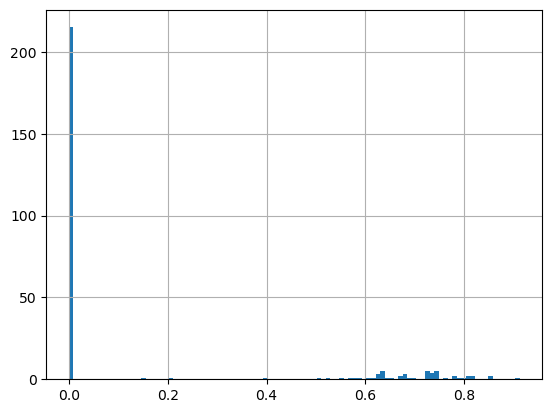

In [27]:
score_df = score_df.sort_values("score", ascending=False).reset_index(drop=True)
display(score_df.head(3))
score_df["score"].hist(bins=100)